<a href="https://colab.research.google.com/github/parkyw2/parkyw2/blob/main/%EA%B8%B0%EC%9E%AC%ED%92%88_%EC%86%8C%EB%AA%A8%ED%92%88%EB%B9%84_%EA%B3%B5%EC%9E%A5%EB%B3%84v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython
%matplotlib inline
!pip install pystan~=2.14
!pip install fbprophet
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My\ Drive/회사 데이터

/content/drive/My Drive/회사 데이터


In [4]:
df = pd.read_csv('소모품비_기재품_plant.csv')

In [5]:
df.tail(10)

,date,1110,1120,1130,1140,1150,1160,1170,1180,total
1086,2021-12-22,4193400,1400600,0,2224040,12058740,1691700,466210,1445400,23480090
1087,2021-12-23,10788600,1317958,0,1878800,462870,0,1211400,78000,15737628
1088,2021-12-24,0,136300,0,567400,0,2484400,557320,0,3745420
1089,2021-12-25,0,0,0,0,0,0,0,0,0
1090,2021-12-26,0,0,0,0,0,0,0,0,0
1091,2021-12-27,10026356,3562000,0,2223180,0,4850900,3431300,2737980,26831716
1092,2021-12-28,3716000,0,0,0,0,5757400,1325800,774900,11574100
1093,2021-12-29,145800,0,0,387100,0,6234849,336700,583300,7687749
1094,2021-12-30,388360,835300,0,3468040,10233600,9261860,570800,0,24757960
1095,2021-12-31,0,651600,0,183400,-205956,3487730,491100,0,4607874


In [6]:
df2 = df.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]

In [7]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('소모품비_기재품_20220321').sheet1

rows = worksheet.get_all_values()
print(rows)

df_new = pd.DataFrame.from_records(rows)
df_new = df_new[1:]
df_new.columns = ["date", "1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180", "total"]
df_new = df_new.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]
df_new = df_new.fillna(0)
df_new = df_new.astype({'1110':'int','1120':'int','1130':'int','1140':'int','1150':'int','1160':'int','1170':'int','1180':'int'})

[['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180', 'total'], ['2022-01-01', '0', '0', '0', '0', '0', '0', '0', '437400', '437400'], ['2022-01-02', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['2022-01-03', '1449988', '3048156', '0', '301800', '0', '0', '2979700', '0', '7779644'], ['2022-01-04', '3529158', '3196086', '0', '1460000', '0', '1394720', '0', '744500', '10324464'], ['2022-01-05', '4048164', '1960834', '0', '3919473', '0', '0', '1309640', '0', '11238111'], ['2022-01-06', '2989300', '2212852', '0', '1934400', '0', '1927020', '684120', '0', '9747692'], ['2022-01-07', '1575610', '0', '0', '3911400', '0', '4237732', '0', '1850400', '11575142'], ['2022-01-08', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['2022-01-09', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['2022-01-10', '995080', '5595100', '0', '520300', '0', '0', '1318718', '0', '8429198'], ['2022-01-11', '2262475', '776800', '0', '0', '0', '1528620', '1219280', '0', '5787175'], ['2022-01-12', '

In [8]:
df2 = pd.concat([df2,df_new], axis = 0)

In [9]:
df_date = df2['date']
df2 = df2[["1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180"]]
df2[df2 < 0] = 0
df = pd.concat([df_date, df2], axis=1)
df.tail(3)

,date,1110,1120,1130,1140,1150,1160,1170,1180
413,2023-02-17,2028000,151500,0,883210,0,722740,1414000,892200
414,2023-02-18,0,0,0,0,0,0,0,0
415,2023-02-19,0,0,0,0,0,0,0,0


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [10]:
from datetime import datetime

#안양
df_1110 = df[['date','1110']]
df_1110['ds'] = pd.to_datetime(df['date'])
df_1110['y'] = df_1110['1110']
df_1110 = df_1110.loc[:,['ds', 'y']]
df_1110['ds'] = pd.to_datetime(df_1110['ds'])
df_1110 = df_1110[df_1110['ds'].dt.dayofweek < 5]
df_1110['date_index'] = df_1110['ds']
df_1110 = df_1110.set_index('date_index')
df_1110['cap'] = 30000000
df_1110['floor'] = 0
df_1110 = df_1110[datetime(2019, 1, 1):datetime(2023, 2, 19)]

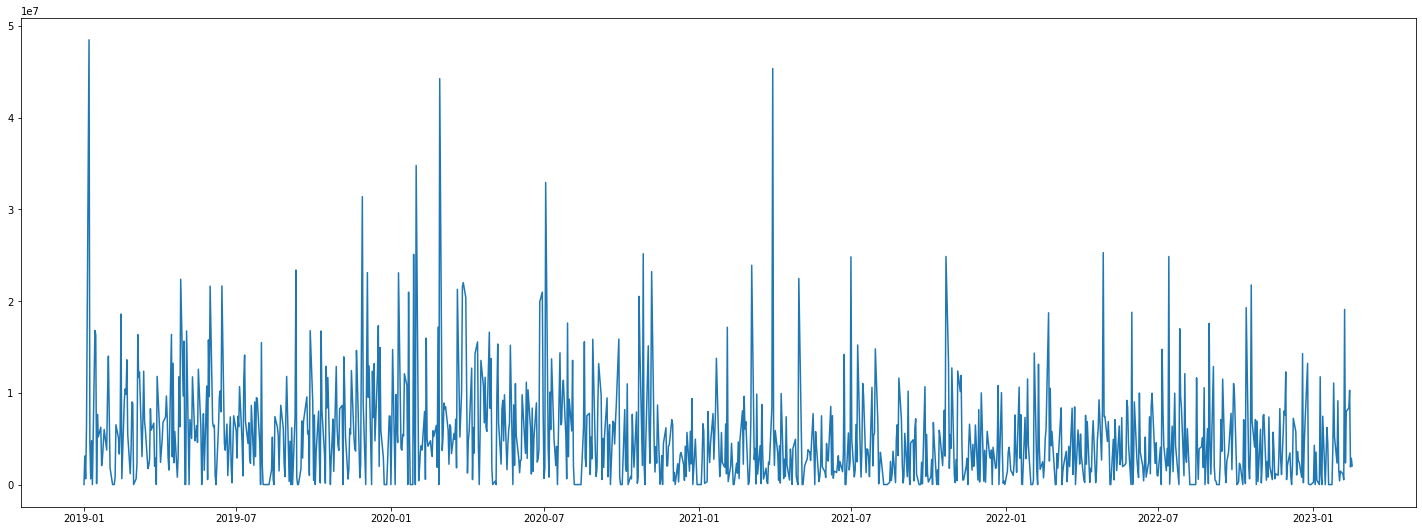

In [11]:
plt.figure(figsize = (25, 9))
plt.plot(df_1110.index,df_1110.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [12]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1110)

future = m.make_future_dataframe(periods=11)    # periods 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 25000000
future['floor'] = 0

forecast=m.predict(future)
preds= forecast['yhat'][:-7]     # 숫자 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


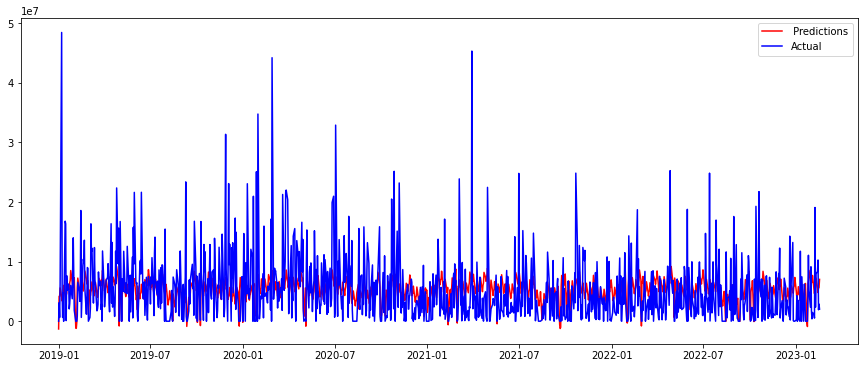

In [13]:
plt.figure(figsize=(15,6))
plt.plot(df_1110.index,preds,color='red',label=' Predictions')
plt.plot(df_1110.index,df_1110.y,color='blue',label='Actual')
plt.legend()
plt.show()

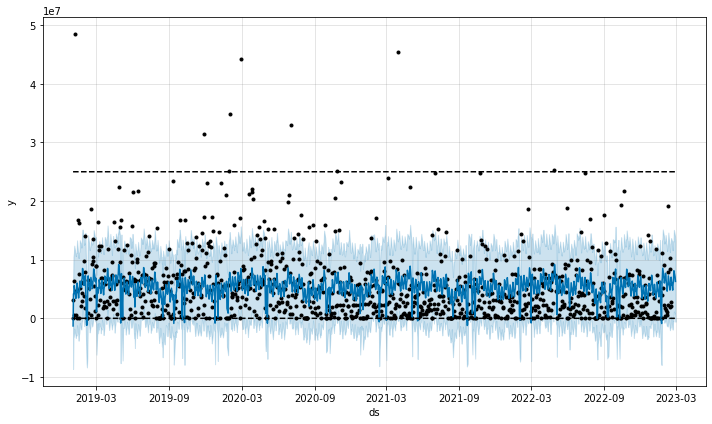

In [14]:
fig = m.plot(m.predict(future))

In [15]:
r2 = round(r2_score(df_1110["y"], preds), 3)
mse = round(mean_squared_error(df_1110["y"], preds), 3)
mae = round(mean_absolute_error(df_1110["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.088
MSE:  28644574333596.773
MAE:  3740077.707


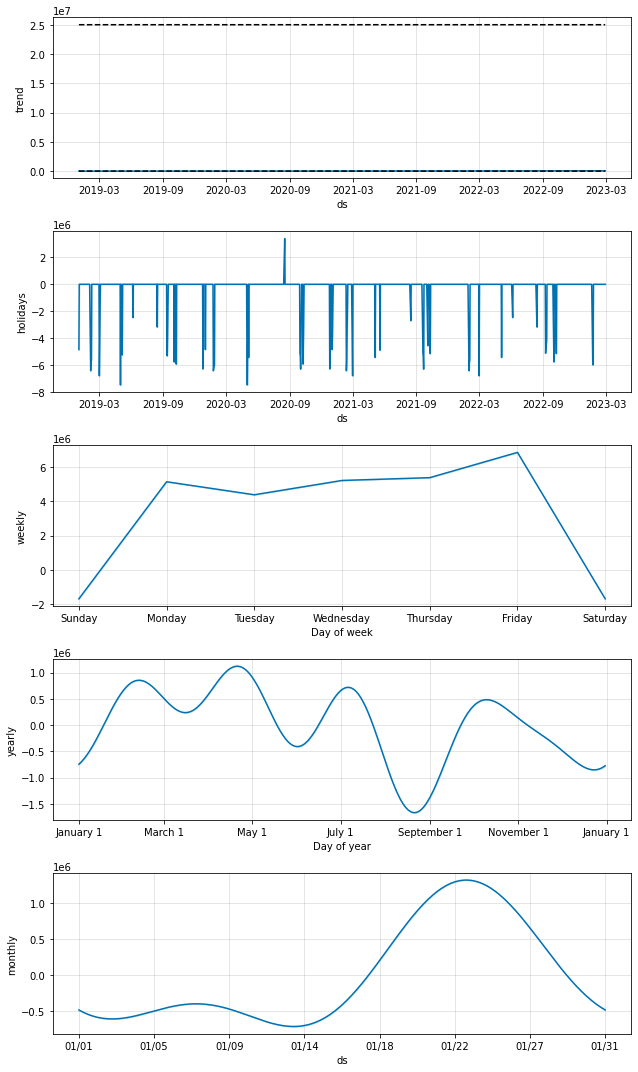

In [16]:
fig = m.plot_components(forecast)

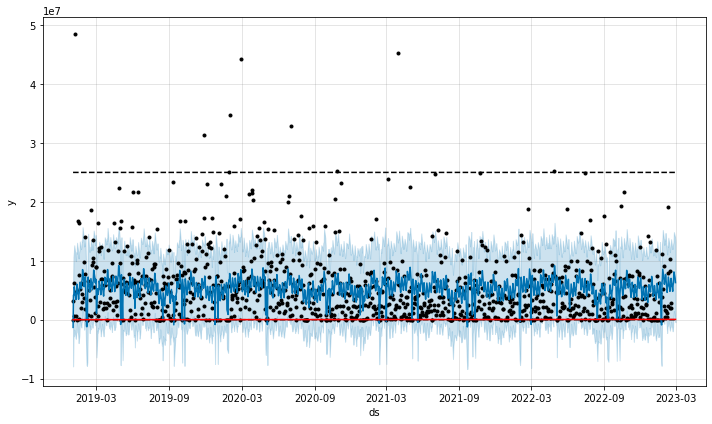

In [17]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [18]:
  pd.options.display.float_format = '{:,.0f}'.format

In [19]:
final_1110 = forecast[['ds', 'yhat']]
final_1110['yhat_1110'] = final_1110['yhat']
final_1110 = final_1110[['ds', 'yhat_1110']]
final_1110.tail()

,ds,yhat_1110
1081,2023-02-22,"5,885,789"
1082,2023-02-23,"6,339,142"
1083,2023-02-24,"8,112,695"
1084,2023-02-27,"7,032,183"
1085,2023-02-28,"6,296,333"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [20]:
#Ansung

df_1120 = df[['date','1120']]
df_1120['ds'] = pd.to_datetime(df_1120['date'])
df_1120['y'] = df_1120['1120']
df_1120 = df_1120.loc[:,['ds', 'y']]
df_1120['ds'] = pd.to_datetime(df_1120['ds'])
df_1120 = df_1120[df_1120['ds'].dt.dayofweek < 5]
df_1120['date_index'] = df_1120['ds']
df_1120 = df_1120.set_index('date_index')
df_1120['cap'] = 30000000
df_1120['floor'] = 0
df_1120 = df_1120[datetime(2019, 1, 1):datetime(2023, 2, 19)]

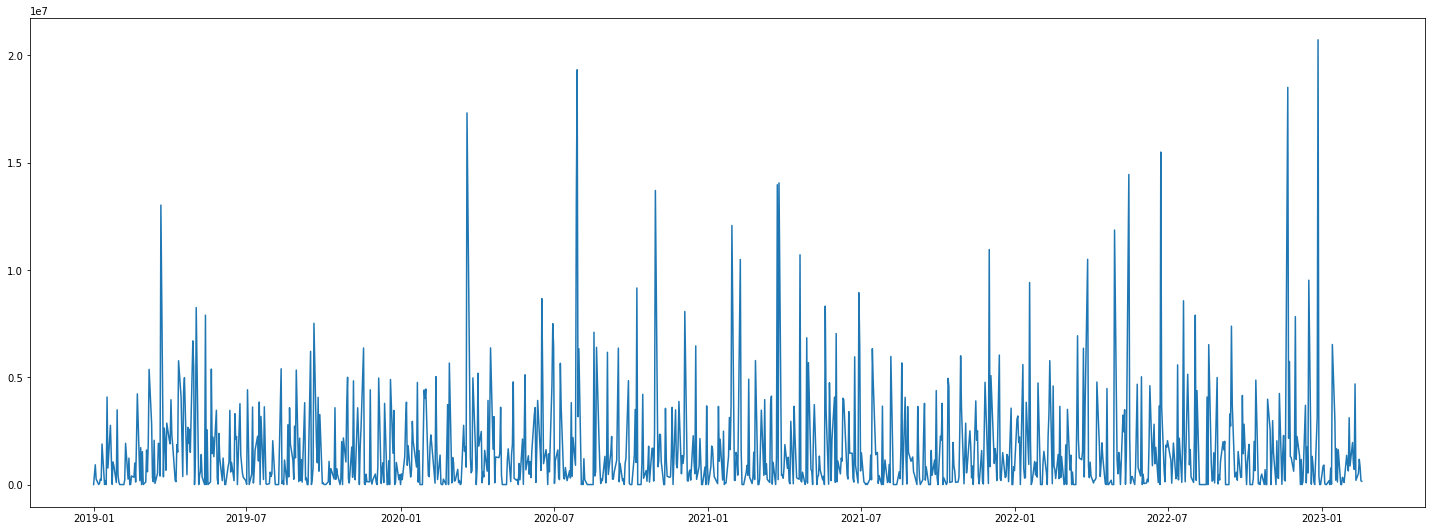

In [21]:
plt.figure(figsize = (25, 9))
plt.plot(df_1120.index,df_1120.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [22]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1120)

future = m.make_future_dataframe(periods=11)             # periods를 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0
forecast=m.predict(future)
preds= forecast['yhat'][:-7]                  # 숫자를 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


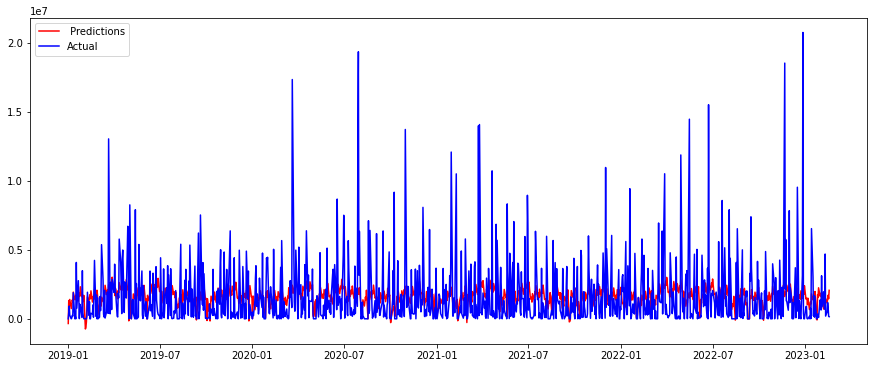

In [23]:
plt.figure(figsize=(15,6))
plt.plot(df_1120.index,preds,color='red',label=' Predictions')
plt.plot(df_1120.index,df_1120.y,color='blue',label='Actual')
plt.legend()
plt.show()

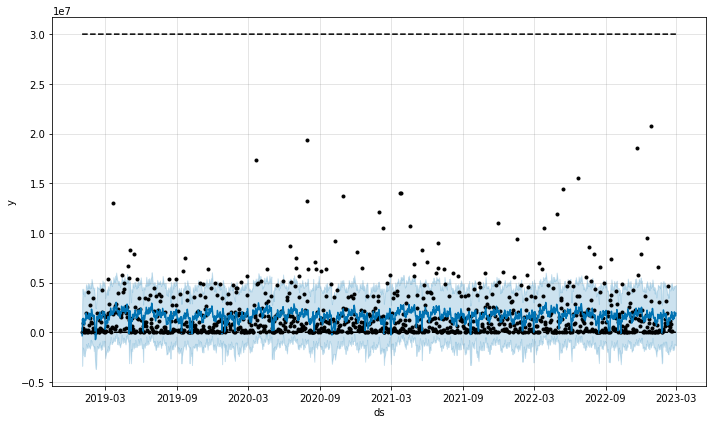

In [24]:
fig = m.plot(m.predict(future))

In [25]:
r2 = round(r2_score(df_1120["y"], preds), 3)
mse = round(mean_squared_error(df_1120["y"], preds), 3)
mae = round(mean_absolute_error(df_1120["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.055
MSE:  5483806212744.374
MAE:  1530029.571


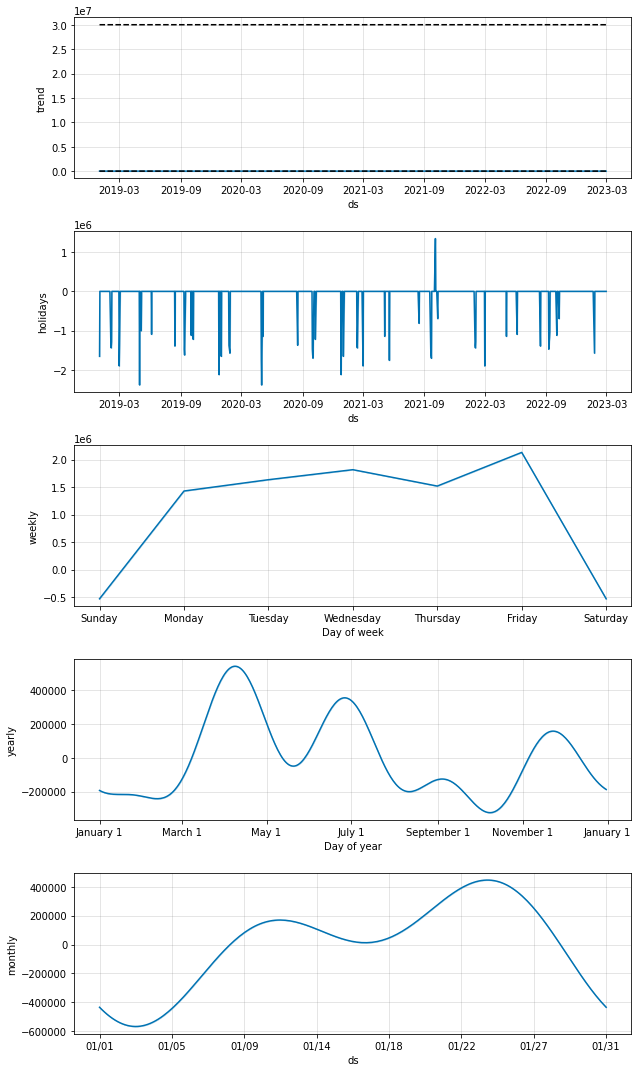

In [26]:
fig = m.plot_components(forecast)

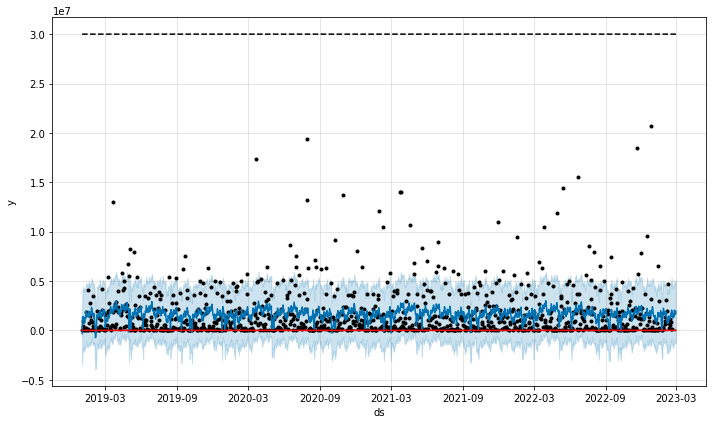

In [27]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [28]:
final_1120 = forecast[['ds', 'yhat']]
final_1120['yhat_1120'] = final_1120['yhat']
final_1120 = final_1120[['ds', 'yhat_1120']]
final_1120.tail()

,ds,yhat_1120
1081,2023-02-22,"1,623,613"
1082,2023-02-23,"1,365,650"
1083,2023-02-24,"2,049,413"
1084,2023-02-27,"1,638,500"
1085,2023-02-28,"1,913,827"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [29]:
#Asan

df_1140 = df[['date','1140']]
df_1140['ds'] = pd.to_datetime(df_1140['date'])
df_1140['y'] = df_1140['1140']
df_1140 = df_1140.loc[:,['ds', 'y']]

df_1140['ds'] = pd.to_datetime(df_1140['ds'])
df_1140 = df_1140[df_1140['ds'].dt.dayofweek < 5]
df_1140['date_index'] = df_1140['ds']
df_1140 = df_1140.set_index('date_index')
df_1140['cap'] = 30000000
df_1140['floor'] = 0

df_1140 = df_1140[datetime(2019, 1, 1):datetime(2023, 2, 19)]

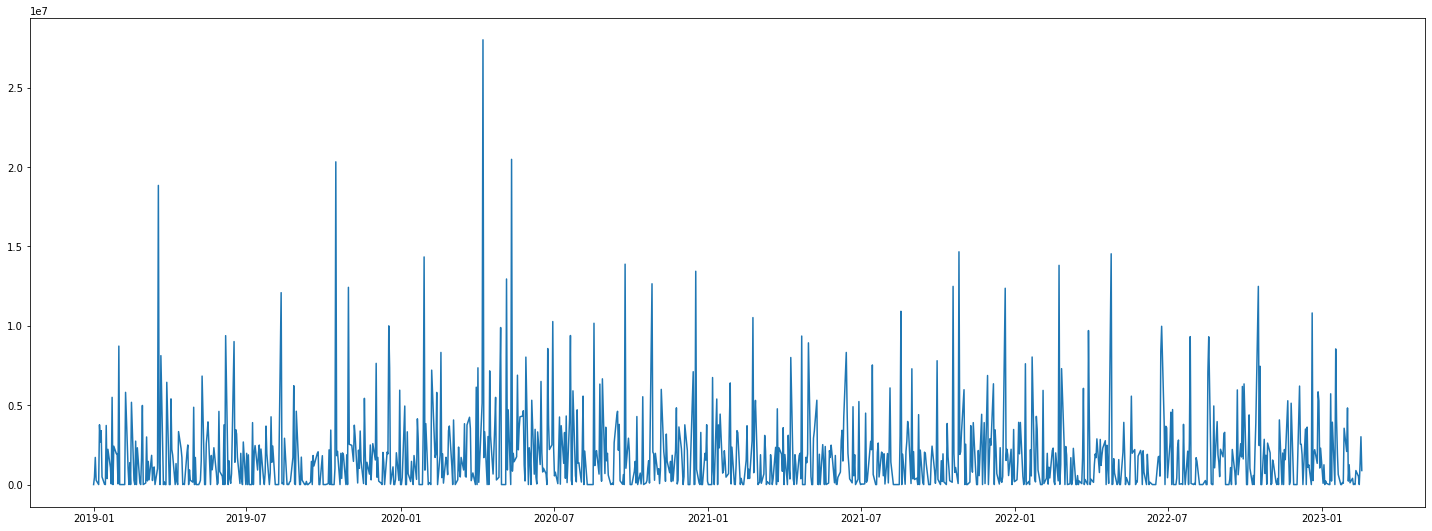

In [30]:
plt.figure(figsize = (25, 9))
plt.plot(df_1140.index,df_1140.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [31]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1140)

future = m.make_future_dataframe(periods=11)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 15000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


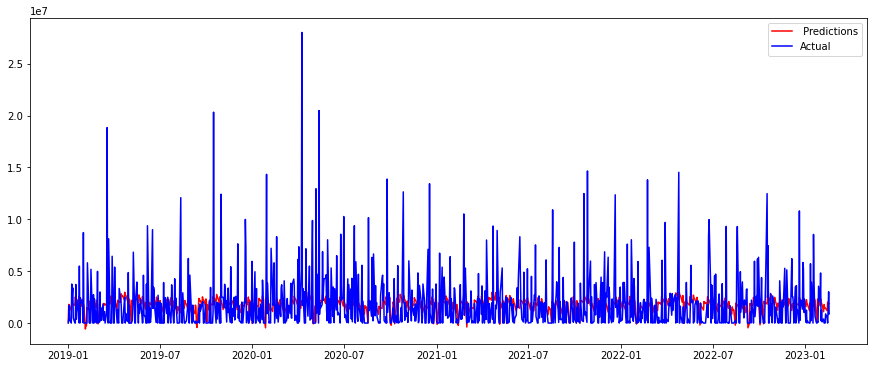

In [32]:
plt.figure(figsize=(15,6))
plt.plot(df_1140.index,preds,color='red',label=' Predictions')
plt.plot(df_1140.index,df_1140.y,color='blue',label='Actual')
plt.legend()
plt.show()

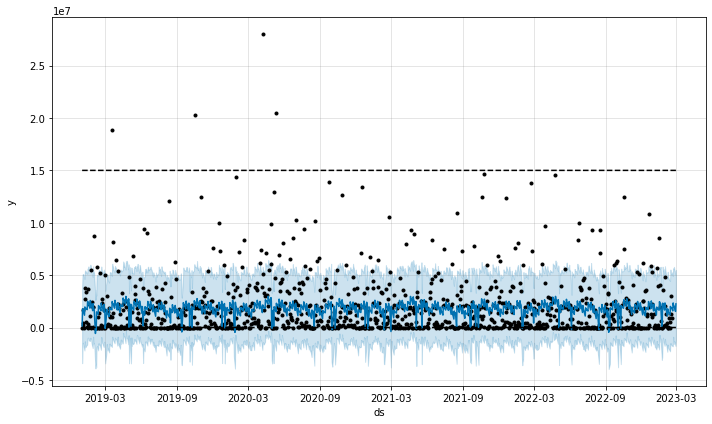

In [33]:
fig = m.plot(m.predict(future))

In [34]:
r2 = round(r2_score(df_1140["y"], preds), 3)
mse = round(mean_squared_error(df_1140["y"], preds), 3)
mae = round(mean_absolute_error(df_1140["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.043
MSE:  7155035444437.135
MAE:  1735651.438


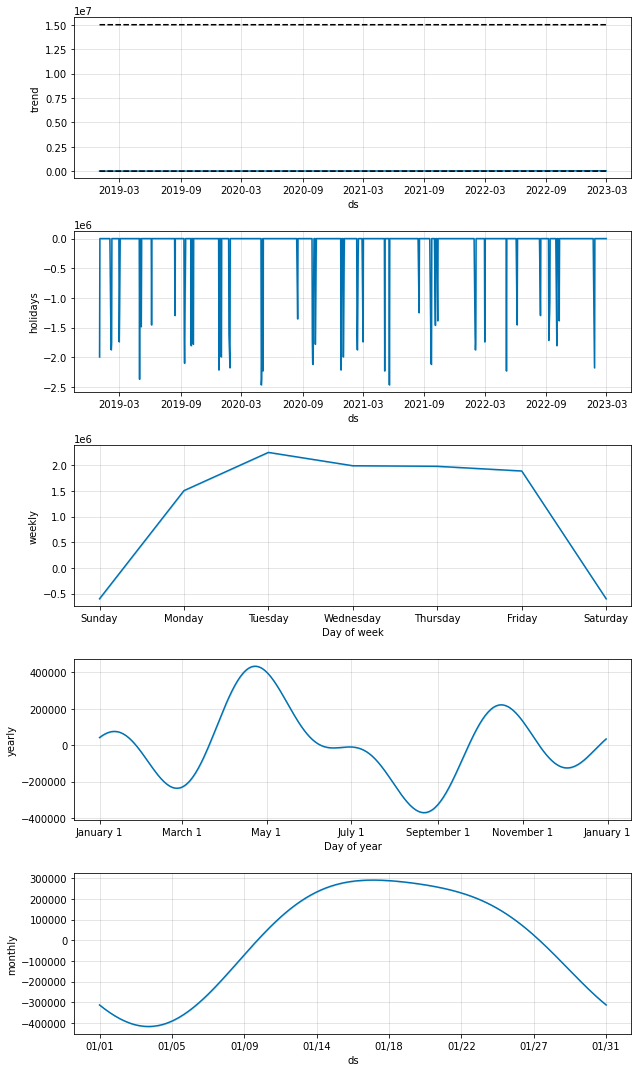

In [35]:
fig = m.plot_components(forecast)

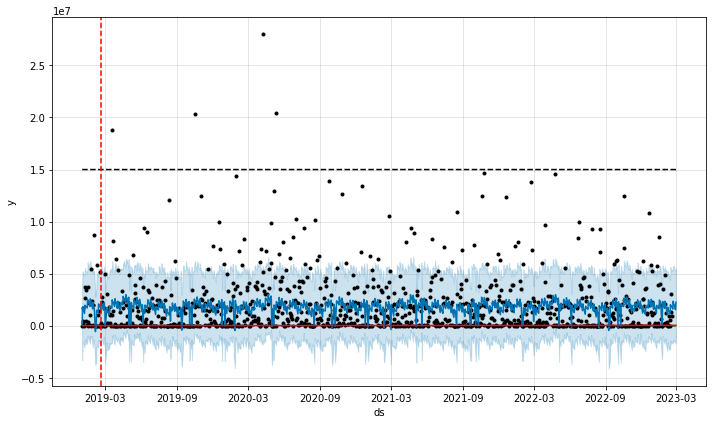

In [36]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [37]:
final_1140 = forecast[['ds', 'yhat']]
final_1140['yhat_1140'] = final_1140['yhat']
final_1140 = final_1140[['ds', 'yhat_1140']]
final_1140.tail()

,ds,yhat_1140
1081,2023-02-22,"2,084,111"
1082,2023-02-23,"2,066,961"
1083,2023-02-24,"1,965,929"
1084,2023-02-27,"1,536,825"
1085,2023-02-28,"2,256,467"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [38]:
#Poseung

df_1150 = df[['date','1150']]
df_1150['ds'] = pd.to_datetime(df_1150['date'])
df_1150['y'] = df_1150['1150']
df_1150 = df_1150.loc[:,['ds', 'y']]

df_1150['ds'] = pd.to_datetime(df_1150['ds'])
df_1150 = df_1150[df_1150['ds'].dt.dayofweek < 5]
df_1150['date_index'] = df_1150['ds']
df_1150 = df_1150.set_index('date_index')
df_1150['cap'] = 30000000
df_1150['floor'] = 0

df_1150 = df_1150[datetime(2019, 1, 1):datetime(2023, 2, 19)]

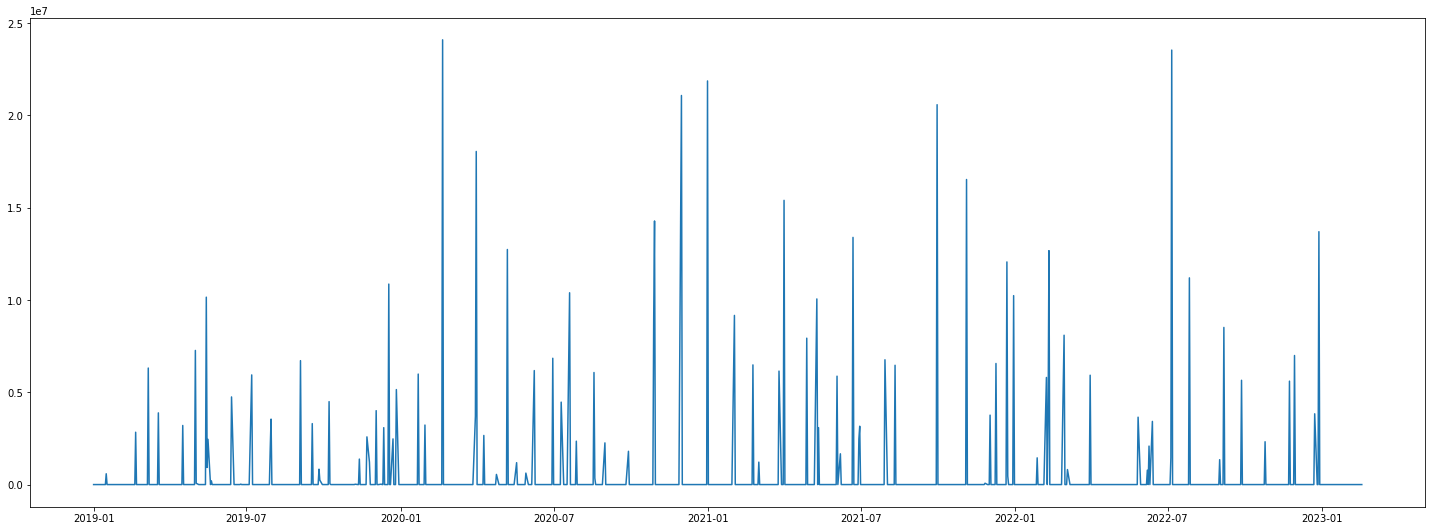

In [39]:
plt.figure(figsize = (25, 9))
plt.plot(df_1150.index,df_1150.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)



In [40]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1150)

future = m.make_future_dataframe(periods=11)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


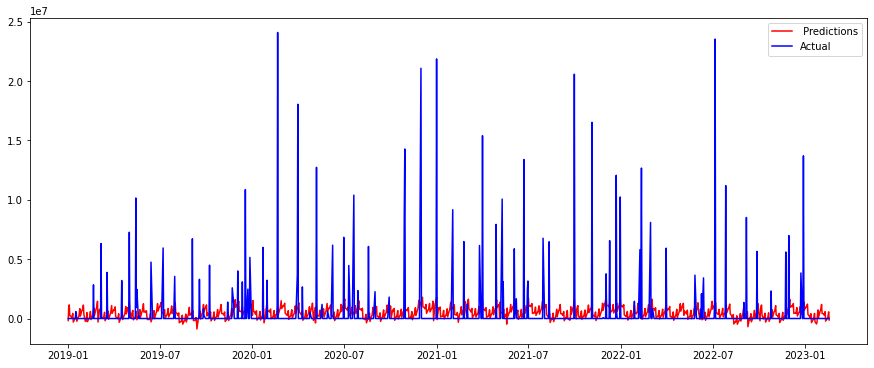

In [41]:
plt.figure(figsize=(15,6))
plt.plot(df_1150.index,preds,color='red',label=' Predictions')
plt.plot(df_1150.index,df_1150.y,color='blue',label='Actual')
plt.legend()
plt.show()

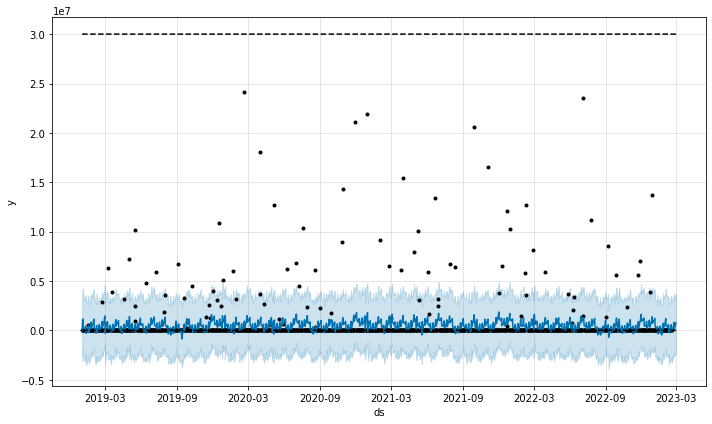

In [42]:
fig = m.plot(m.predict(future))

In [43]:
r2 = round(r2_score(df_1150["y"], preds), 3)
mse = round(mean_squared_error(df_1150["y"], preds), 3)
mae = round(mean_absolute_error(df_1150["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.036
MSE:  5523328909765.478
MAE:  987019.761


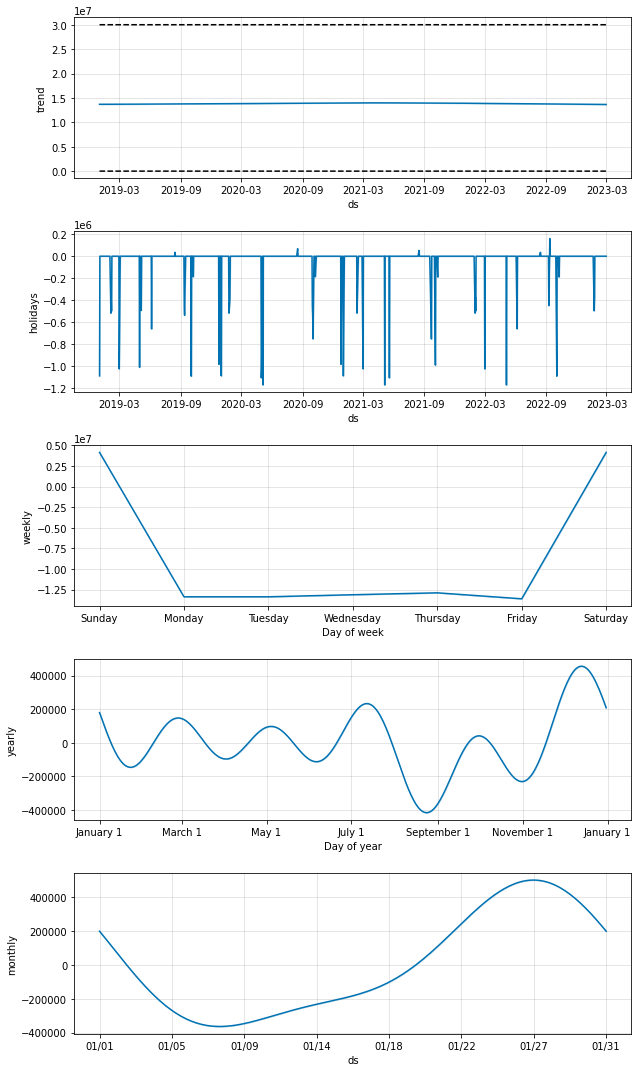

In [44]:
fig = m.plot_components(forecast)

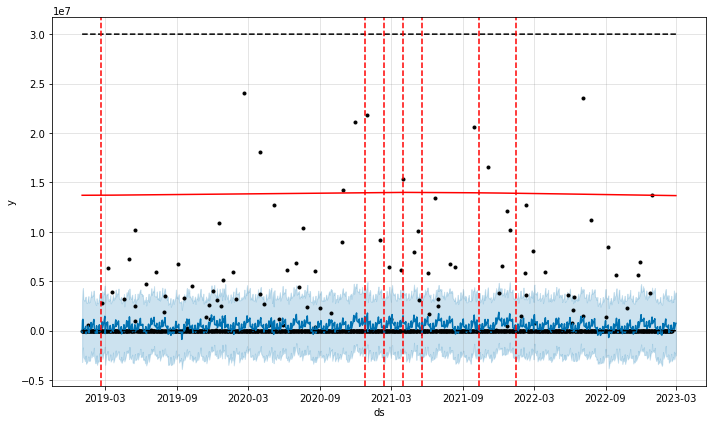

In [45]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [46]:
final_1150 = forecast[['ds', 'yhat']]
final_1150['yhat_1150'] = final_1150['yhat']
final_1150 = final_1150[['ds', 'yhat_1150']]
final_1150.tail()

,ds,yhat_1150
1081,2023-02-22,"532,591"
1082,2023-02-23,"812,419"
1083,2023-02-24,"150,719"
1084,2023-02-27,"652,614"
1085,2023-02-28,"745,481"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [47]:
#GUMI
df_1160 = df[['date','1160']]
df_1160['ds'] = pd.to_datetime(df_1160['date'])
df_1160['y'] = df_1160['1160']
df_1160 = df_1160.loc[:,['ds', 'y']]

df_1160['ds'] = pd.to_datetime(df_1160['ds'])
df_1160 = df_1160[df_1160['ds'].dt.dayofweek < 5]
df_1160['date_index'] = df_1160['ds']
df_1160 = df_1160.set_index('date_index')
df_1160['cap'] = 30000000
df_1160['floor'] = 0

df_1160 = df_1160[datetime(2019, 1, 1):datetime(2023, 2, 19)]

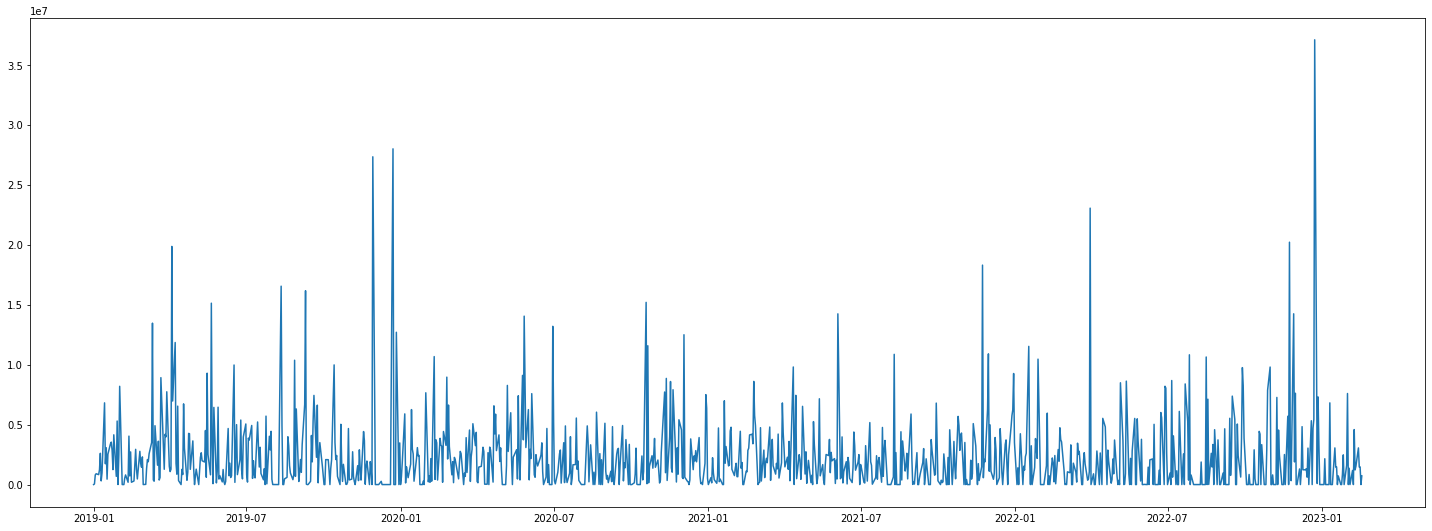

In [48]:
plt.figure(figsize = (25, 9))
plt.plot(df_1160.index,df_1160.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [49]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1160)

future = m.make_future_dataframe(periods=11)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


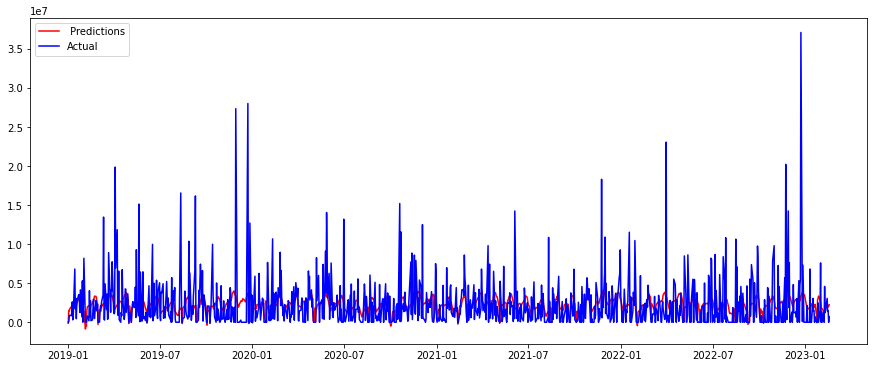

In [50]:
plt.figure(figsize=(15,6))
plt.plot(df_1160.index,preds,color='red',label=' Predictions')
plt.plot(df_1160.index,df_1160.y,color='blue',label='Actual')
plt.legend()
plt.show()

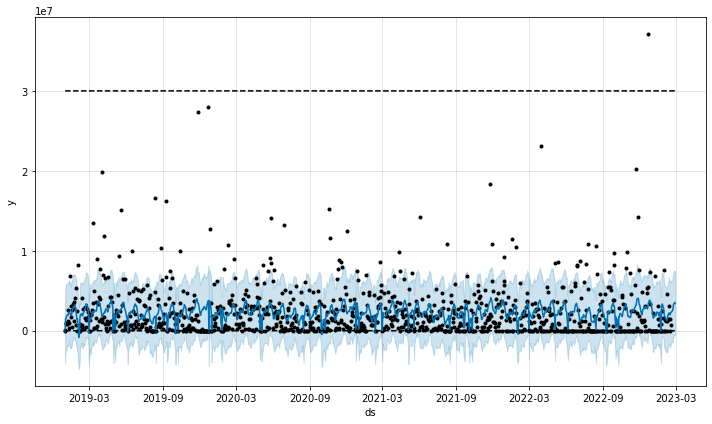

In [51]:
fig = m.plot(m.predict(future))

In [52]:
r2 = round(r2_score(df_1160["y"], preds), 3)
mse = round(mean_squared_error(df_1160["y"], preds), 3)
mae = round(mean_absolute_error(df_1160["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.066
MSE:  9639520514775.816
MAE:  1951446.414


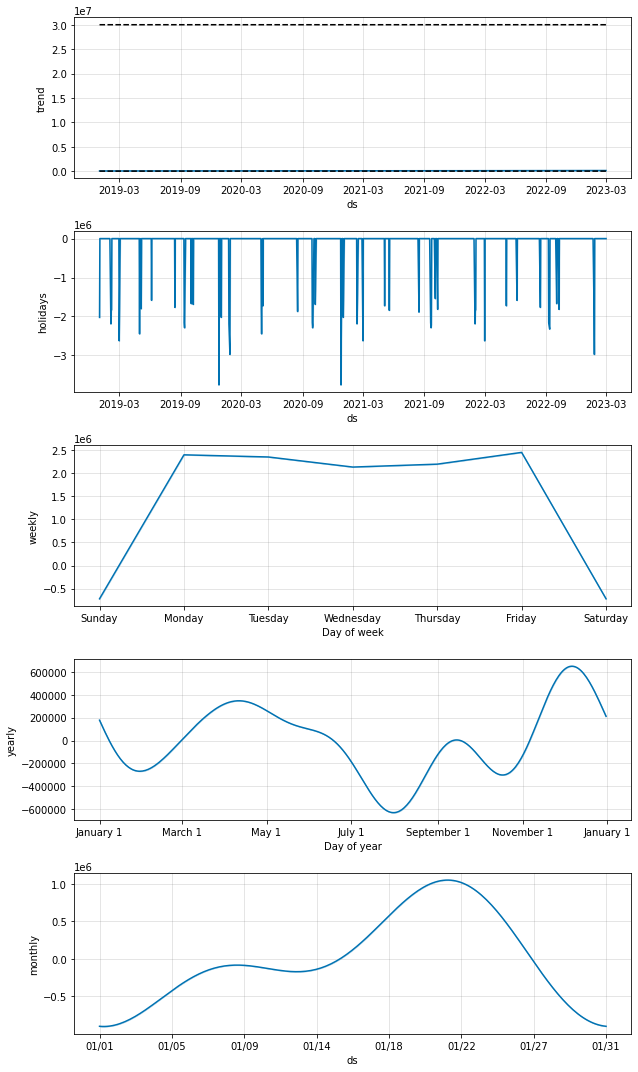

In [53]:
fig = m.plot_components(forecast)

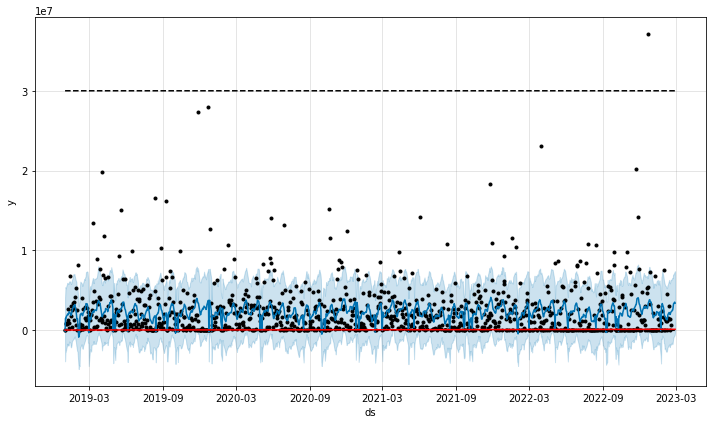

In [54]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [55]:
final_1160 = forecast[['ds', 'yhat']]
final_1160['yhat_1160'] = final_1160['yhat']
final_1160 = final_1160[['ds', 'yhat_1160']]
final_1160.tail()

,ds,yhat_1160
1081,2023-02-22,"2,533,101"
1082,2023-02-23,"2,827,051"
1083,2023-02-24,"3,298,032"
1084,2023-02-27,"3,526,036"
1085,2023-02-28,"3,390,805"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [56]:
#Pusan
df_1170 = df[['date','1170']]
df_1170['ds'] = pd.to_datetime(df_1170['date'])
df_1170['y'] = df_1170['1170']
df_1170 = df_1170.loc[:,['ds', 'y']]

df_1170['ds'] = pd.to_datetime(df_1170['ds'])
df_1170 = df_1170[df_1170['ds'].dt.dayofweek < 5]
df_1170['date_index'] = df_1170['ds']
df_1170 = df_1170.set_index('date_index')
df_1170['cap'] = 30000000
df_1170['floor'] = 0

df_1170 = df_1170[datetime(2019, 1, 1):datetime(2023, 2, 19)]

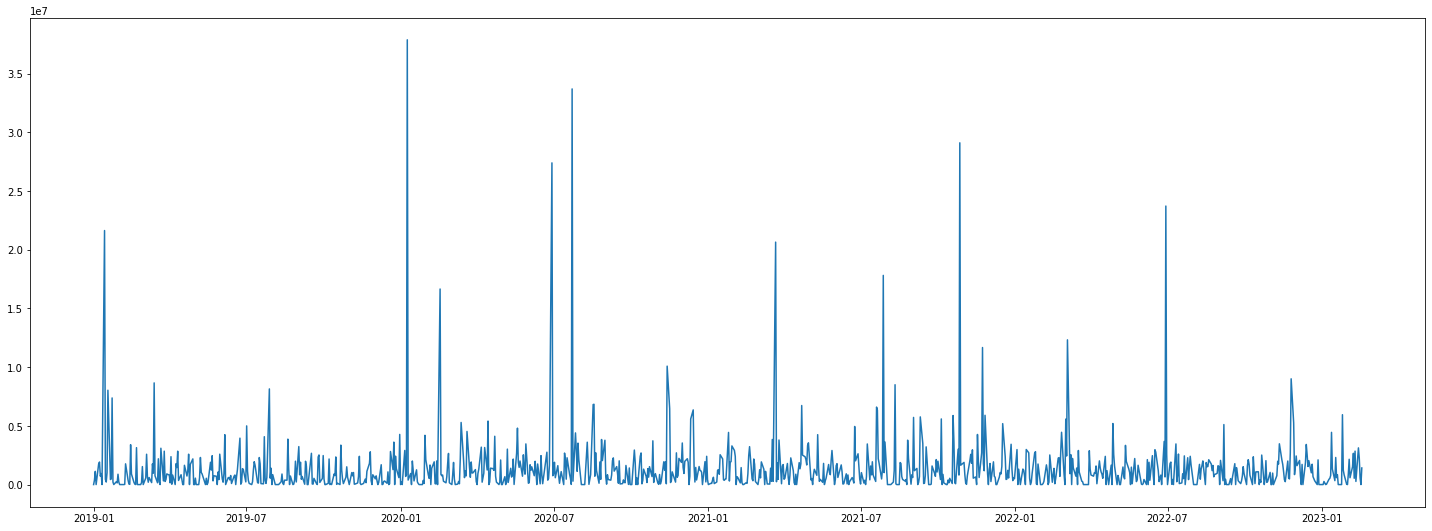

In [57]:
plt.figure(figsize = (25, 9))
plt.plot(df_1170.index,df_1170.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [58]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1170)

future = m.make_future_dataframe(periods=11)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


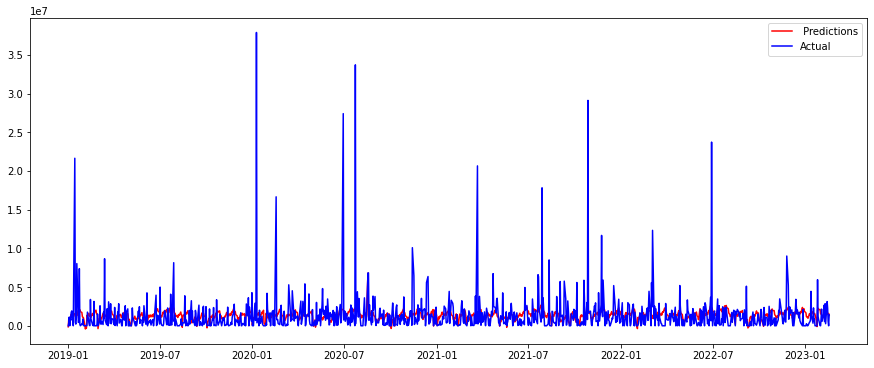

In [59]:
plt.figure(figsize=(15,6))
plt.plot(df_1170.index,preds,color='red',label=' Predictions')
plt.plot(df_1170.index,df_1170.y,color='blue',label='Actual')
plt.legend()
plt.show()

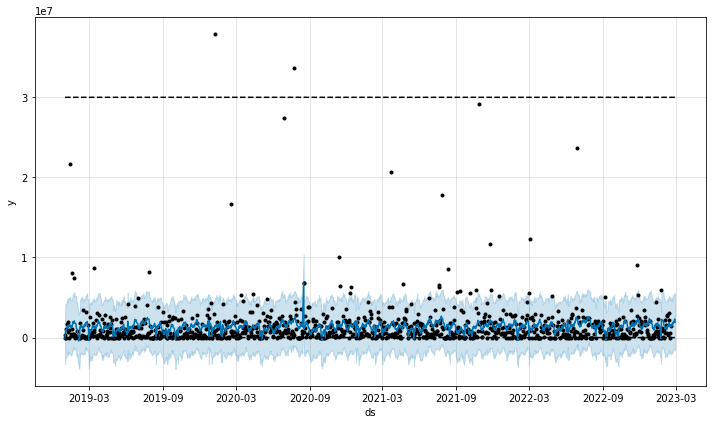

In [60]:
fig = m.plot(m.predict(future))

In [61]:
r2 = round(r2_score(df_1170["y"], preds), 3)
mse = round(mean_squared_error(df_1170["y"], preds), 3)
mae = round(mean_absolute_error(df_1170["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.038
MSE:  7036904917440.48
MAE:  1216336.729


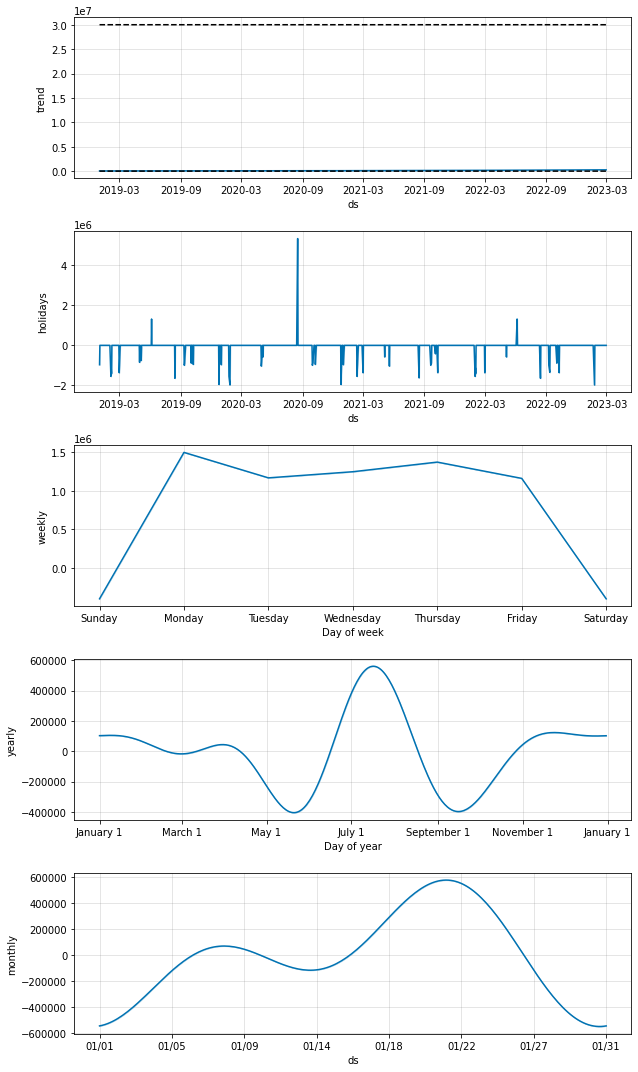

In [62]:
fig = m.plot_components(forecast)

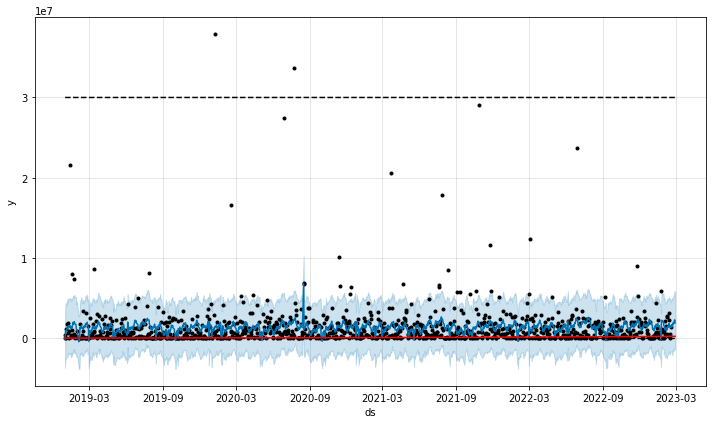

In [63]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [64]:
final_1170 = forecast[['ds', 'yhat']]
final_1170['yhat_1170'] = final_1170['yhat']
final_1170 = final_1170[['ds', 'yhat_1170']]
final_1170.tail()

,ds,yhat_1170
1081,2023-02-22,"1,669,395"
1082,2023-02-23,"1,927,059"
1083,2023-02-24,"1,839,976"
1084,2023-02-27,"2,314,184"
1085,2023-02-28,"1,912,985"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [65]:
#Noksan

df_1180 = df[['date','1180']]
df_1180['ds'] = pd.to_datetime(df_1180['date'])
df_1180['y'] = df_1180['1180']
df_1180 = df_1180.loc[:,['ds', 'y']]

df_1180['ds'] = pd.to_datetime(df_1180['ds'])
df_1180 = df_1180[df_1180['ds'].dt.dayofweek < 5]
df_1180['date_index'] = df_1180['ds']
df_1180 = df_1180.set_index('date_index')
df_1180['cap'] = 30000000
df_1180['floor'] = 0

df_1180 = df_1180[datetime(2019, 1, 1):datetime(2023, 2, 19)]

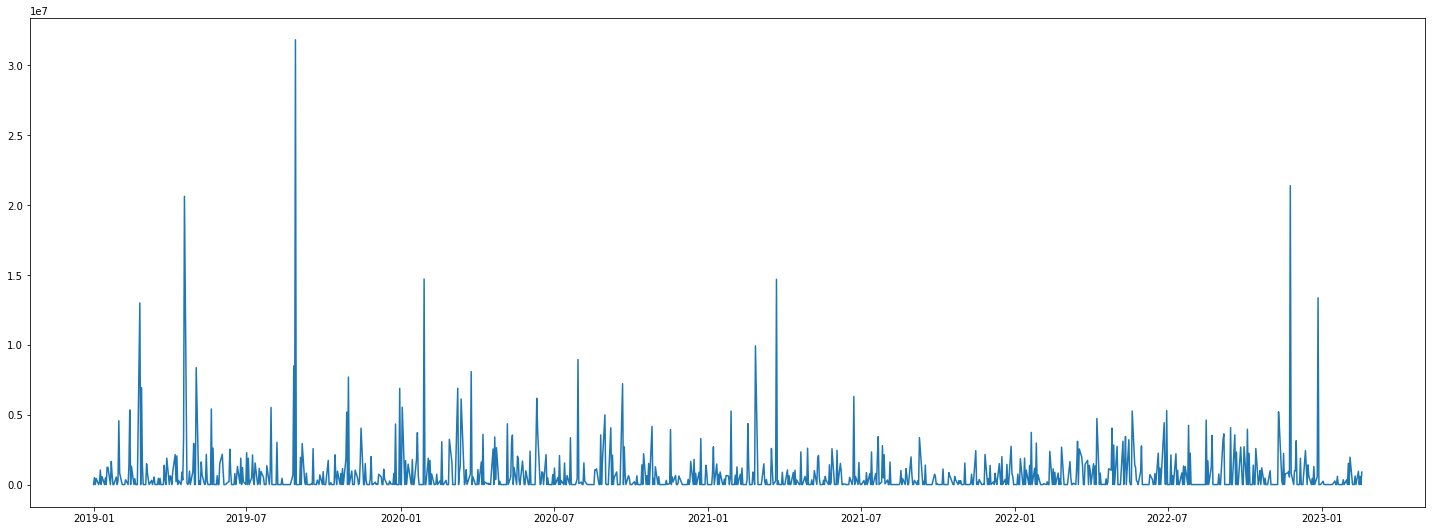

In [66]:
plt.figure(figsize = (25, 9))
plt.plot(df_1180.index,df_1180.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [67]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1180)

future = m.make_future_dataframe(periods=11)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 10000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


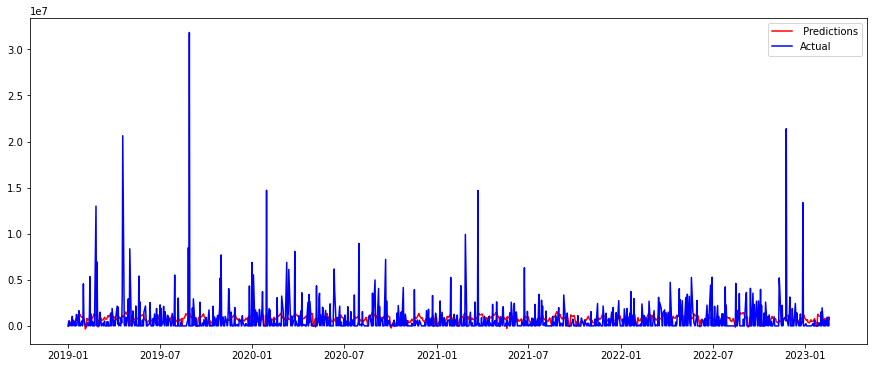

In [68]:
plt.figure(figsize=(15,6))
plt.plot(df_1180.index,preds,color='red',label=' Predictions')
plt.plot(df_1180.index,df_1180.y,color='blue',label='Actual')
plt.legend()
plt.show()

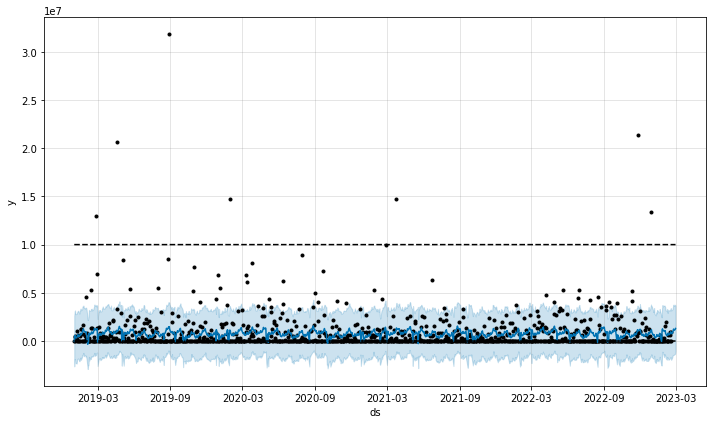

In [69]:
fig = m.plot(m.predict(future))

In [70]:
r2 = round(r2_score(df_1180["y"], preds), 3)
mse = round(mean_squared_error(df_1180["y"], preds), 3)
mae = round(mean_absolute_error(df_1180["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.025
MSE:  3851943639026.496
MAE:  993137.586


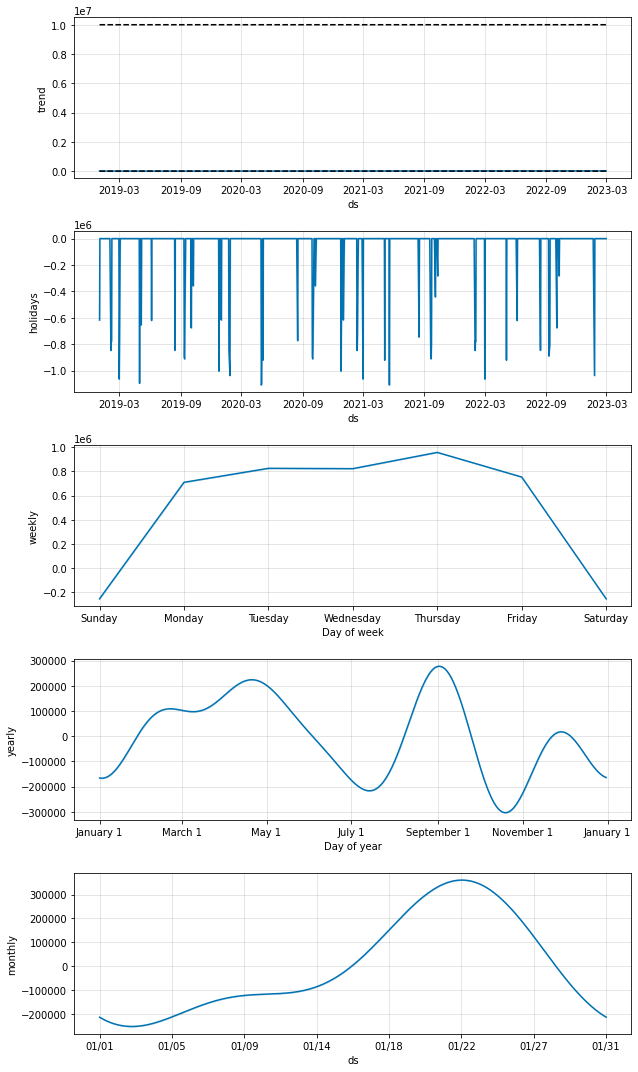

In [71]:
fig = m.plot_components(forecast)

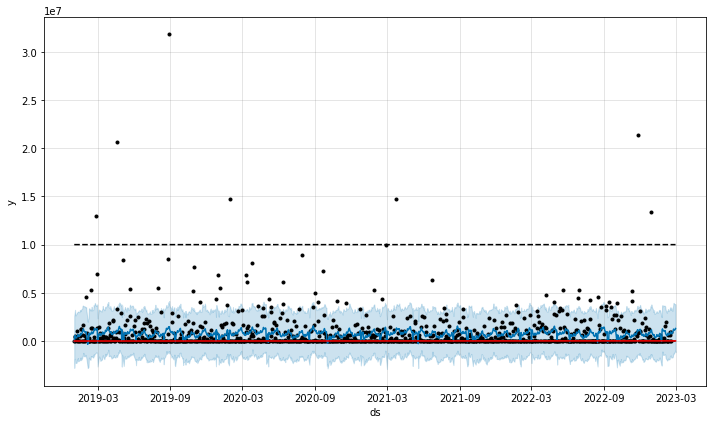

In [72]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [73]:
final_1180 = forecast[['ds', 'yhat']]
final_1180['yhat_1180'] = final_1180['yhat']
final_1180 = final_1180[['ds', 'yhat_1180']]
final_1180.tail()

,ds,yhat_1180
1081,2023-02-22,"1,032,043"
1082,2023-02-23,"1,238,526"
1083,2023-02-24,"1,106,007"
1084,2023-02-27,"1,190,704"
1085,2023-02-28,"1,300,120"


In [74]:
final_1110['date_index'] = final_1110['ds']
final_1110 = final_1110.set_index('date_index')

final_1120['date_index'] = final_1120['ds']
final_1120 = final_1120.set_index('date_index')

final_1140['date_index'] = final_1140['ds']
final_1140 = final_1140.set_index('date_index')

final_1150['date_index'] = final_1150['ds']
final_1150 = final_1150.set_index('date_index')

final_1160['date_index'] = final_1160['ds']
final_1160 = final_1160.set_index('date_index')

final_1170['date_index'] = final_1170['ds']
final_1170 = final_1170.set_index('date_index')

final_1180['date_index'] = final_1180['ds']
final_1180 = final_1180.set_index('date_index')

In [75]:
final_1110 = final_1110[730:]
final_1120 = final_1120[730:]
final_1140 = final_1140[730:]
final_1150 = final_1150[730:]
final_1160 = final_1160[730:]
final_1170 = final_1170[730:]
final_1180 = final_1180[730:]

In [76]:
final_total = pd.merge(final_1110, final_1120)
final_total = pd.merge(final_total, final_1140)
final_total = pd.merge(final_total, final_1150)
final_total = pd.merge(final_total, final_1160)
final_total = pd.merge(final_total, final_1170)
final_total = pd.merge(final_total, final_1180)

In [77]:
final_total['final_sum'] = final_total['yhat_1110'] + final_total['yhat_1120'] + final_total['yhat_1140'] + final_total['yhat_1150'] + final_total['yhat_1160'] +final_total['yhat_1170'] + final_total['yhat_1180']


✅final_total.tail(8) 에서 8 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [78]:
final_total.tail(7)

,ds,yhat_1110,yhat_1120,yhat_1140,yhat_1150,yhat_1160,yhat_1170,yhat_1180,final_sum
349,2023-02-20,"5,386,919","1,249,921","1,591,343","211,518","2,404,747","1,709,296","799,203","13,352,946"
350,2023-02-21,"4,806,848","1,434,519","2,344,455","243,691","2,534,821","1,469,456","968,970","13,802,760"
351,2023-02-22,"5,885,789","1,623,613","2,084,111","532,591","2,533,101","1,669,395","1,032,043","15,360,643"
352,2023-02-23,"6,339,142","1,365,650","2,066,961","812,419","2,827,051","1,927,059","1,238,526","16,576,808"
353,2023-02-24,"8,112,695","2,049,413","1,965,929","150,719","3,298,032","1,839,976","1,106,007","18,522,771"
354,2023-02-27,"7,032,183","1,638,500","1,536,825","652,614","3,526,036","2,314,184","1,190,704","17,891,046"
355,2023-02-28,"6,296,333","1,913,827","2,256,467","745,481","3,390,805","1,912,985","1,300,120","17,816,018"
